<a href="https://colab.research.google.com/github/haneenbadr/Brain-Tumor-with-ResNet50/blob/main/brain_Tumor_Resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

mv: cannot stat 'kaggle.json': No such file or directory


In [10]:
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection

Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
License(s): copyright-authors
brain-mri-images-for-brain-tumor-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix


In [12]:
from zipfile import ZipFile
file_name = "/content/brain-mri-images-for-brain-tumor-detection.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [13]:
dataset_path = "/content/brain_tumor_dataset"

In [14]:
import os
import shutil
import random


dataset_path = "/content/brain_tumor_dataset"
classes = ['yes', 'no']


train_dir = os.path.join(dataset_path, 'train')
val_dir = os.path.join(dataset_path, 'val')
test_dir = os.path.join(dataset_path, 'test')


for dir_path in [train_dir, val_dir, test_dir]:
    for cls in classes:
        os.makedirs(os.path.join(dir_path, cls), exist_ok=True)


for cls in classes:
    class_path = os.path.join(dataset_path, cls)
    images = os.listdir(class_path)
    random.shuffle(images)

    train_split = int(0.7 * len(images))
    val_split = int(0.9 * len(images))

    train_images = images[:train_split]
    val_images = images[train_split:val_split]
    test_images = images[val_split:]

    for img in train_images:
        shutil.move(os.path.join(class_path, img), os.path.join(train_dir, cls, img))

    for img in val_images:
        shutil.move(os.path.join(class_path, img), os.path.join(val_dir, cls, img))

    for img in test_images:
        shutil.move(os.path.join(class_path, img), os.path.join(test_dir, cls, img))


In [29]:
datagen = ImageDataGenerator(
    rescale=1./255,
     rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


train_data = datagen.flow_from_directory(
    os.path.join(dataset_path, 'train'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

val_data = datagen.flow_from_directory(
    os.path.join(dataset_path, 'val'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

test_data = ImageDataGenerator(rescale=1./255).flow_from_directory(
    os.path.join(dataset_path, 'test'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 231 images belonging to 2 classes.
Found 92 images belonging to 2 classes.
Found 49 images belonging to 2 classes.


In [32]:
from tensorflow.keras.layers import Dropout
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=x)


model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


# early_stopping = EarlyStopping(
#     monitor='val_loss',
#     patience=5,
#     restore_best_weights=True
# )


history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=100,
    # callbacks=[early_stopping]
)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.5181 - loss: 0.7658 - val_accuracy: 0.6087 - val_loss: 0.6812
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 251ms/step - accuracy: 0.5604 - loss: 0.7702 - val_accuracy: 0.6087 - val_loss: 0.6756
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 376ms/step - accuracy: 0.6102 - loss: 0.7094 - val_accuracy: 0.6087 - val_loss: 0.6689
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 252ms/step - accuracy: 0.4603 - loss: 0.8008 - val_accuracy: 0.6087 - val_loss: 0.6594
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 243ms/step - accuracy: 0.5472 - loss: 0.7453 - val_accuracy: 0.6087 - val_loss: 0.6589
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 258ms/step - accuracy: 0.5647 - loss: 0.7045 - val_accuracy: 0.6087 - val_loss: 0.6690
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 470ms/step - accuracy: 0.5925 - loss: 0.7097 - val_accuracy: 0.6087 - val_loss: 0.6629
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 253ms/step - accuracy: 0.5657 - loss: 0.7643 - val_accuracy: 0.6304 - va

In [33]:
test_loss, test_acc = model.evaluate(test_data)
print(f"Test Accuracy: {test_acc:.2f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6741 - loss: 0.6059
Test Accuracy: 0.71


In [34]:
y_true = test_data.classes
y_pred = (model.predict(test_data) > 0.5).astype("int32")
print(classification_report(y_true, y_pred, target_names=list(test_data.class_indices.keys())))

2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step
              precision    recall  f1-score   support

          no       0.86      0.32      0.46        19
         yes       0.69      0.97      0.81        30

    accuracy                           0.71        49
   macro avg       0.77      0.64      0.63        49
weighted avg       0.76      0.71      0.67        49



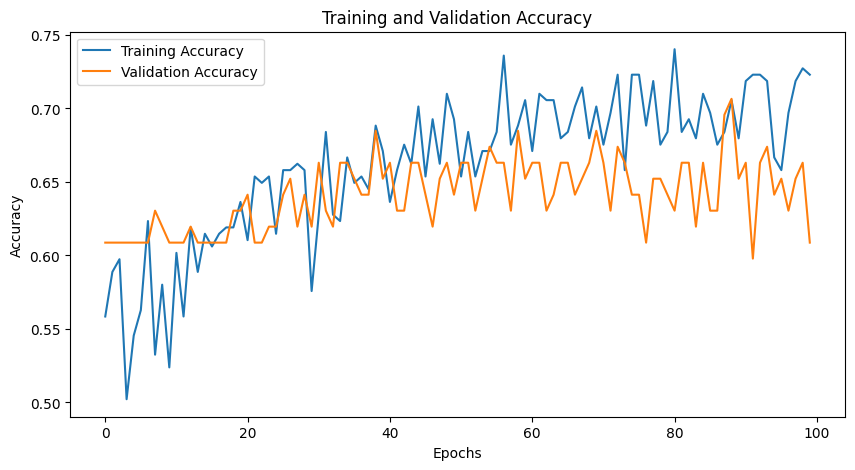

In [35]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

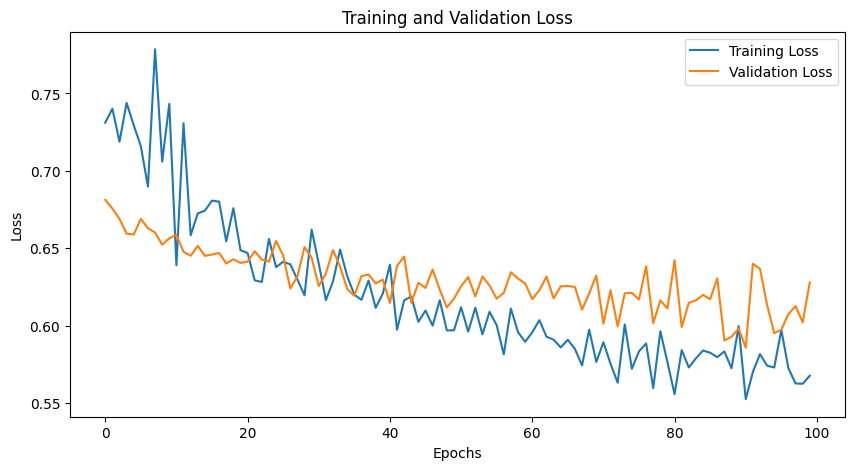

In [36]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

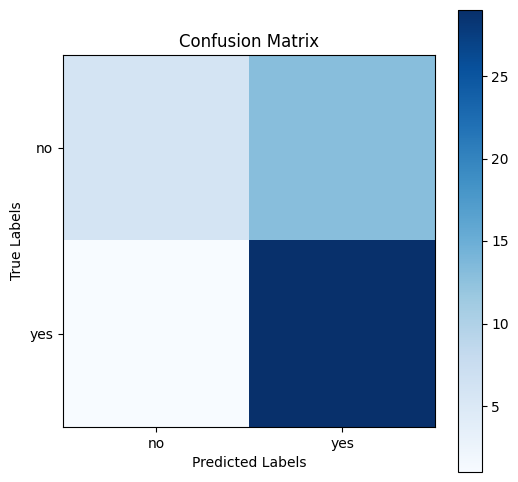

In [37]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks([0, 1], test_data.class_indices.keys())
plt.yticks([0, 1], test_data.class_indices.keys())
plt.show()